## Import required libraries

In [1]:
import pyforest
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from pylab import rcParams
from IPython.display import display
from statsmodels.tsa.stattools import acf,pacf,adfuller,coint
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import  qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing,VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## read Ice-creame_Vs_Heater dataset

In [2]:
df = pd.read_csv("ice-creame_vs_heater.csv")
df.head()

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      180 non-null    object
 1   heater     180 non-null    int64 
 2   ice cream  180 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.3+ KB


## convert data into time series

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


## plot the time series

<Figure size 1200x600 with 0 Axes>

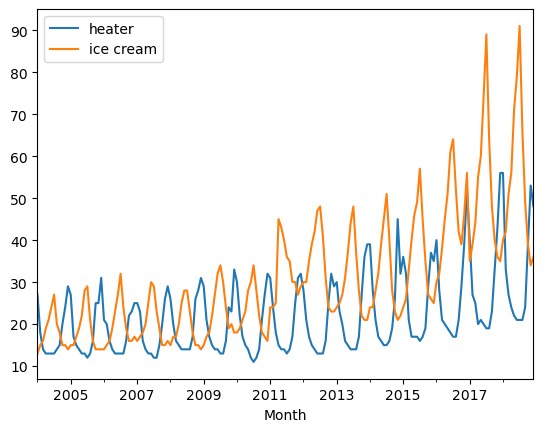

In [6]:
plt.figure(figsize=(12,6))
df.plot()
plt.show()

## establish the presence of a statistically significant connection between ice-cream and heater time series using Cointegration test for alpha= 0.05.

In [9]:
result = coint(df['heater'], df['ice cream'])
p_value = result[1]

if p_value < 0.05:
    print("TSF are cointegrated ")
else:
    print("TSF not cointegrated.")

TSF not cointegrated.


## split the series into training and testing sets

In [10]:
train, test = train_test_split(df,test_size=(36/df.shape[0]),random_state=10,shuffle=False)
print(f"Train size = {train.shape[0]} and Test size = { test.shape[0]}")

Train size = 144 and Test size = 36


## check for stationarity

In [11]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]  # Return the p-value

# Check stationarity for both series
heater_p_value = check_stationarity(train['heater'])
ice_cream_p_value = check_stationarity(train['ice cream'])

if heater_p_value < 0.05 and ice_cream_p_value < 0.05:
    print("Both time series are stationary.")
else:
    print("At least one time series is not stationary. Apply differencing.")

ADF Statistic: 0.43415689495869286
p-value: 0.9827283161654216
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579
ADF Statistic: -0.5239080878017253
p-value: 0.8872659504830542
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
At least one time series is not stationary. Apply differencing.


## If series is not stationary, use differencing to make the series stationary

In [12]:
df_diff = df.diff().dropna()

# Check stationarity again after differencing
heater_p_value = check_stationarity(df_diff['heater'])
ice_cream_p_value = check_stationarity(df_diff['ice cream'])

if heater_p_value < 0.05 and ice_cream_p_value < 0.05:
    print("Both time series are stationary.")
else:
    print("At least one time series is not stationary. Apply differencing.")

ADF Statistic: -5.140771634946358
p-value: 1.1600459083969168e-05
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576
ADF Statistic: -4.54764146087847
p-value: 0.0001611287320767449
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
Both time series are stationary.


##  select the right order of the VAR model for least AIC.

In [13]:
model = VAR(df_diff)
best_order = model.select_order()
print("Best order selected by AIC:", best_order.aic)

Best order selected by AIC: 12


## Train the VAR model for selected order

In [14]:
var_model = VAR(df_diff)
var_fitted = var_model.fit(best_order.aic)

## forecast using fitted model

In [15]:
train_size = int(train.shape[0])
train, test = df_diff[:train_size], df_diff[train_size:]

# Forecast using fitted model
forecast = var_fitted.forecast(train.values[-best_order.aic:], steps=len(test))

## If differencing is done, Invert the transformation to get the real forecast

In [16]:
forecast_values = []
last_observation = train.values[-1]  # Get the last observation from the training set

for i in range(len(forecast)):
    forecast_values.append(forecast[i] + last_observation)
    last_observation = forecast_values[-1]  # Update last observation for next iteration

forecast_values = pd.DataFrame(forecast_values, index=test.index, columns=test.columns)

## plot the results

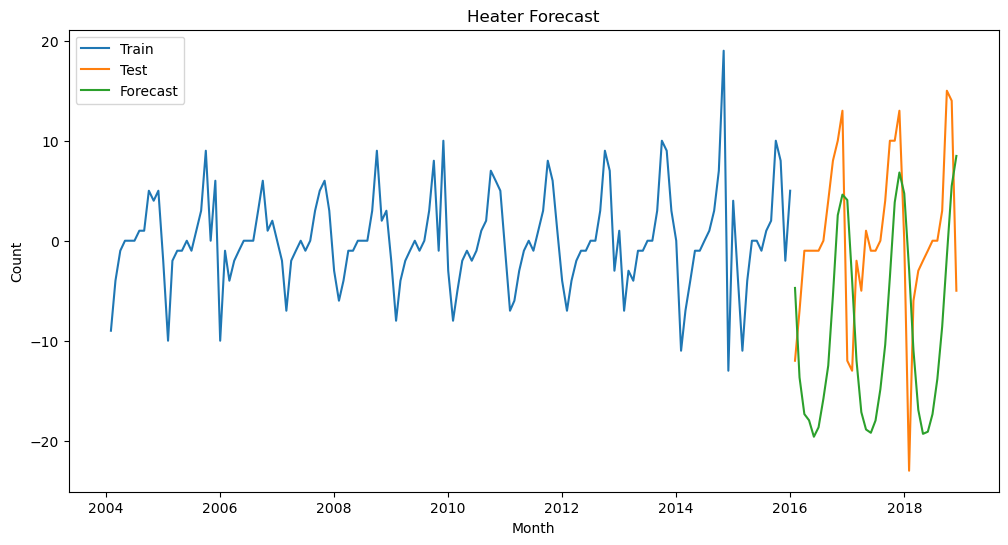

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['heater'], label='Train')
plt.plot(test.index, test['heater'], label='Test')
plt.plot(forecast_values.index, forecast_values['heater'], label='Forecast')
plt.title('Heater Forecast')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show()

## END